<a href="https://colab.research.google.com/github/drkrillo/DATASCIENCE/blob/main/Crypto_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!pip install Historic-Crypto

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
from Historic_Crypto import LiveCryptoData, HistoricalData
import pandas as pd
from google.colab import drive
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.backend import dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, MaxPooling2D, Dropout,Conv1D, RepeatVector, TimeDistributed
from tensorflow import keras
import random
from tensorflow.keras.utils import set_random_seed
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from sklearn import metrics # for the evalution

In [32]:
btc = HistoricalData('ETH-USD',86400,'2020-06-01-00-00').retrieve_data()

Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is available on the CoinBase Pro API.
Connected to the CoinBase Pro API.
Ticker 'ETH-USD' found at the CoinBase Pro API, continuing to extraction.
Provisional Start: 2020-06-01T00:00:00
Provisional End: 2021-03-28T00:00:00
Data for chunk 1 of 3 extracted
Provisional Start: 2021-03-28T00:00:00
Provisional End: 2022-01-22T00:00:00
Data for chunk 2 of 3 extracted
Provisional Start: 2022-01-22T00:00:00
Provisional End: 2022-11-18T00:00:00
Data for chunk 3 of 3 extracted


In [33]:
btc.shape

(856, 5)

In [34]:
btc.close.tail(2)

time
2022-10-04    1362.06
2022-10-05    1320.72
Name: close, dtype: float64

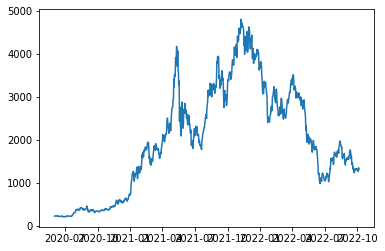

In [35]:
plt.plot(btc.close)

In [36]:
btc.tail(10)

,low,high,open,close,volume
time,,,,,
2022-09-26,1278.24,1341.00,1294.65,1336.61,416561.978054
2022-09-27,1303.66,1400.51,1336.45,1327.92,457125.646047
2022-09-28,1253.65,1355.34,1327.87,1336.93,488408.682704
2022-09-29,1288.12,1351.85,1336.92,1336.02,409208.961750
2022-09-30,1315.00,1373.46,1336.04,1328.95,423994.580674
2022-10-01,1302.65,1333.99,1328.74,1311.76,98845.973281
2022-10-02,1269.69,1318.00,1311.79,1277.02,150803.126007
2022-10-03,1262.45,1330.24,1276.84,1323.31,341841.340020
2022-10-04,1318.82,1370.43,1323.44,1362.06,265741.947257


In [37]:
window_size = 30

def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    counter = 1
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
      if i < window_size:
        pass
      else:
        indices = range(i - window, i)
        X.append(dataset[indices])

        indicey = range(i, i+horizon)
        y.append(target[indicey])

        counter+=1
    return np.array(X), np.array(y)

In [38]:
validate = btc[[ 'low', 'high', 'open', 'close', 'volume']].tail(1)
btc.drop(btc.tail(1).index,inplace=True)

In [39]:
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(btc[[ 'low', 'high', 'open', 'close', 'volume']])
Y_data = Y_scaler.fit_transform(np.array(btc['close']).reshape(-1,1))

In [40]:
horizon = 1
TRAIN_SPLIT = round(0.86 * len(btc))
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, window_size, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, window_size, horizon)

In [41]:
y_train.shape,y_vali.shape, btc.shape

((705, 1, 1), (119, 1, 1), (855, 5))

In [42]:
btc.shape

(855, 5)

In [43]:
batch_size = 64
buffer_size = 30

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

In [44]:
from tensorflow.keras.layers import Layer
from keras import backend as K

class attention(Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences

        super(attention,self).__init__()

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="normal")
        
        super(attention,self).build(input_shape)


    def call(self, x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        if self.return_sequences:

            return output
        return K.sum(output, axis=1)

In [45]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300, return_sequences=True), 
                               input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(20, activation='tanh'),

    tf.keras.layers.Dense(40, activation='tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=horizon),
])
lstm_model.compile(optimizer='adam', loss='mse')

In [46]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 30, 600)          734400    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 30, 20)            12020     
                                                                 
 bidirectional_3 (Bidirectio  (None, 300)              205200    
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 20)                6020      
                                                                 
 dense_8 (Dense)             (None, 40)                840       
                                                                 
 dropout_1 (Dropout)         (None, 40)               

In [47]:
model_path = 'Bidirectional_LSTM_Multivariate.h5'

# Definimos parámetros para parar el entrenamiento
early_stopping = EarlyStopping(
    monitor = 'val_loss', # Estudiamos función de costo
    patience = 20, # Número de epochs sin mejora
    min_delta = 1e-5, # Mínmo cambio tomado como mejora
    mode = 'auto'
)
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)

callbacks=[early_stopping,checkpoint]

In [48]:
history = lstm_model.fit(train_data,epochs=1000,steps_per_epoch=10,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)

Epoch 1/1000
10/10 [==============================] - 32s 2s/step - loss: 0.0575 - val_loss: 0.0032
Epoch 2/1000
10/10 [==============================] - 9s 1s/step - loss: 0.0237 - val_loss: 0.0030
Epoch 3/1000
10/10 [==============================] - 10s 1s/step - loss: 0.0092 - val_loss: 0.0030
Epoch 4/1000
10/10 [==============================] - 9s 998ms/step - loss: 0.0107 - val_loss: 0.0108
Epoch 5/1000
10/10 [==============================] - 9s 1s/step - loss: 0.0365 - val_loss: 0.0235
Epoch 6/1000
10/10 [==============================] - 9s 1s/step - loss: 0.0132 - val_loss: 0.0032
Epoch 7/1000
10/10 [==============================] - 10s 1s/step - loss: 0.0064 - val_loss: 0.0023
Epoch 8/1000
10/10 [==============================] - 10s 1s/step - loss: 0.0130 - val_loss: 0.0085
Epoch 9/1000
10/10 [==============================] - 10s 1s/step - loss: 0.0133 - val_loss: 0.0018
Epoch 10/1000
10/10 [==============================] - 10s 1s/step - loss: 0.0184 - val_loss: 0.0095


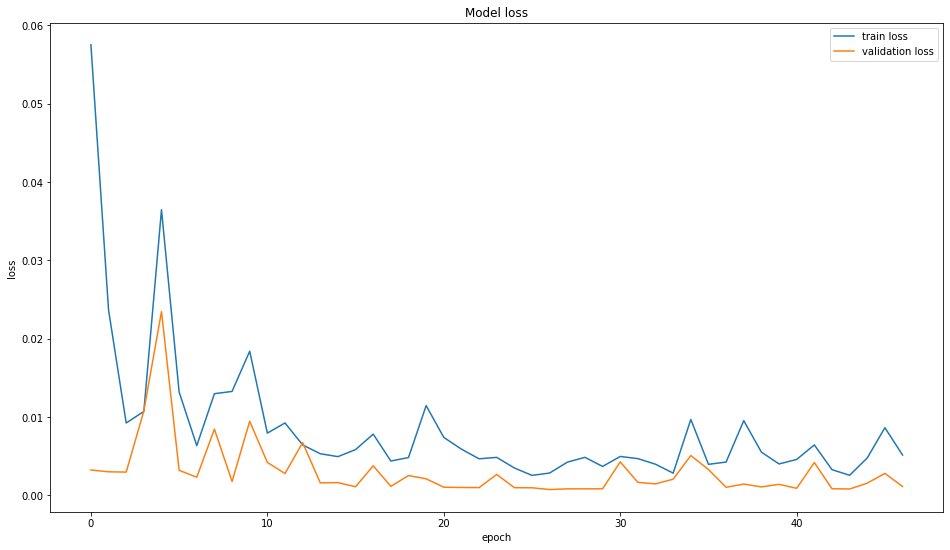

In [49]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [50]:
  data_val = X_scaler.fit_transform(btc[[ 'low', 'high', 'open', 'close', 'volume']].tail(window_size))
  val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

In [51]:
pred = lstm_model.predict(val_rescaled)

In [52]:
pred

array([[0.12704508]], dtype=float32)

In [53]:
pred_Inverse = Y_scaler.inverse_transform(pred)

In [54]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [55]:
timeseries_evaluation_metrics_func(validate['close'],pred_Inverse[0])

Evaluation metric results:-
MSE is : 266956.41604133695
MAE is : 516.678251953125
RMSE is : 516.678251953125
MAPE is : 39.120953112932725
R2 is : nan



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [56]:
validate['close'],pred_Inverse[0]

(time
 2022-10-05    1320.72
 Name: close, dtype: float64, array([804.04175], dtype=float32))

In [57]:
train_predict = lstm_model.predict(x_train)
test_predict = lstm_model.predict(x_vali)

train_predict = Y_scaler.inverse_transform(train_predict)
test_predict = Y_scaler.inverse_transform(test_predict)

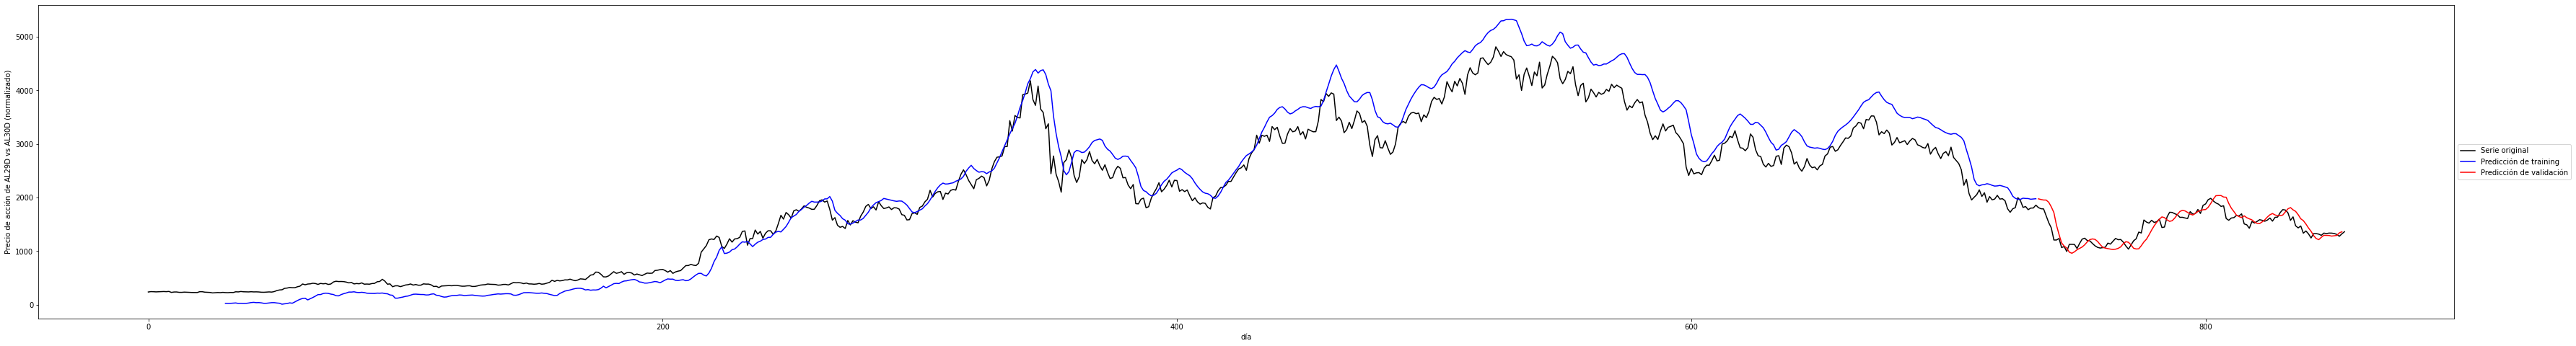

In [58]:
# Graficar serie original
from matplotlib.pyplot import figure
figure(figsize=(60, 8))


plt.plot(list(btc['close']),color = 'k')
# Graficar la predicción de entrenamiento
split_pt = TRAIN_SPLIT
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# Graficar la predicción de validación
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# Agregar rótulos
plt.xlabel('día')
plt.ylabel('Precio de acción de AL29D vs AL30D (normalizado)')
plt.legend(['Serie original','Predicción de training','Predicción de validación'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()